### Description
Mobile provider offers to its clients two different tariff plans. We have datasets which show how many minutes, data and messages were used by each client. Every client can terminate the contract at any moment without any extra fees.
We need to analyse clients' behaviour to tell which tariff plan is better for the operator.

### **Datasets**
<br>*Table users (clients' information):* 
- user_id — unique client's ID
- first_name — client's name
- last_name — client's surname
- age — client's age (in years)
- reg_date — contract date (YYYY-MM-DD)
- churn_date — termination date (it's empty if the contract is still active at the moment of data extraction)
- city — client's town
- tariff — client's tarrif plan

*Table calls (telephone calls' information):*
- id — unique call's ID
- call_date — date of call
- duration — call's duration (in minutes)
- user_id — ID of the client who made this call

*Table messages (information about sms masseges):* 
- id — unique message's ID
- message_date — date of message
- user_id — ID of the client who sent this message

*Table internet (information about internet sessions):* 
- id — unique ID of mobile internet session
- mb_used — volume of used mobile internet during the session (in Mb)
- session_date — date of internet session
- user_id — ID of the client who used thid. internet

*Table tariffs (tariff plans):* 
- tariff_name — tariff plan
- rub_monthly_fee — monthly fee
- minutes_included — telephone calls included (in minutes)
- messages_included — sms included
- mb_per_month_included — mobile internet included (in Mb)
- rub_per_minute — cost of every minute over the inclusive calls
- rub_per_message — cost of every sms over the inclusive ones
- rub_per_gb — cost of every 1Gb of mobile internet over the inclusive package (1Gb = 1024Mb) 


### Tariff plans
<br>**«Smart»**
- Monthly pay: 550 rubles
- 500 minutes of calls, 50 messages, 15Gb data included
- Costs over inclusive:
    - minute of call: 3 rubles
    - message: 3 rubles 
    - 1 Gb data: 200 rubles
   
**«Ultra»**
- Monthly pay: 1950 rubles
- 3000 minutes of calls, 1000 messages, 30 Gb data included
- Costs over inclusive:
    - minute of call: 1 ruble
    - message: 1 ruble
    - 1 Gb data: 150 rubles

*Rounding*: Minutes and mobile data are always rounded up to the next integer. If someone speeks only a second it will be counted like a whole minute.

*All data in datasets is in russian as I made this project during russian course in Yandex*

### Plan
1. [Import data from files](#preprocessing)
2. [Data preparation](#data_preparation): transforming data formats, cleaning data (removing erroneous or unnecessary data)
3. [Pivot table with client characteristic](#clients_info)<br/>Calculate for every client the values below
    - amount of used calls and minutes per months;
    - amount of sent messages per months;
    - used mobile data volume per months;
    - gross proceeds from every user (calculate cost of calls, messages, data over included in the tariff and summarize it with monthly pay for this tariff).
    
    
4. [Data analysis](#data_analysis): describe average behavior of clients (amount of calls, messages, data per month for every tariff)
    - calculate average amount, despersion and standard deviation;
    - create histograms;
    - analyse these distributions and compare with tariff plan services.
    
    
5. [Check hypothesis to choose the best tariff plan](#hypothesis_check):
    - average proceed is different for different tariffs;
    - average proceed is different in Moscow and in other regions.

### 0. Libraries

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import scipy.stats as stats

### 1. Import data from files and analyse it <a id="preprocessing"> <a>

In [2]:
calls = pd.read_csv('calls.csv')
internet = pd.read_csv('internet.csv')
messages = pd.read_csv('messages.csv')
tariffs = pd.read_csv('tariffs.csv')
users = pd.read_csv('users.csv')

In [3]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [4]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [5]:
calls.describe()

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


In [6]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [7]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [8]:
internet.describe()

,Unnamed: 0,mb_used,user_id
count,149396.000000,149396.000000,149396.000000
mean,74697.500000,370.192426,1252.099842
std,43127.054745,278.300951,144.050823
min,0.000000,0.000000,1000.000000
25%,37348.750000,138.187500,1130.000000
50%,74697.500000,348.015000,1251.000000
75%,112046.250000,559.552500,1380.000000
max,149395.000000,1724.830000,1499.000000


In [9]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [10]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [11]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [12]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [13]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [14]:
users.describe()

,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


### First conclusions and checks
*Data types*
<br>We should change data type to date in the fields below:
- calls.call_date
- internet.session_date    
- messages.message_date    
- users.reg_date  

*Erroneous values*
<br>Field duration in table calls - there're calls with zero duration. In reality there shouldn't be such calls. I see couple possible reasons of such data:
- no one answers this call but information about this call was already written in our system;
- log time is not written accurate enough and if the call is very short (like 2-3 seconds) we see zero duration.

<br>To determine the real reason we can test both cases on real phone and see how it will be written in the base. If there're some problems in log system then we'll need to discuss it with IT department. 
In scope of this project we assume that the second guess turned out to be right and we'll replace zero duration calls with 1 minute.

*Empty values*
<br>There're empty values in column churn_date of table users. That's not an error as it means that this client is still active and didn't terminate his contract.

*Dublicates*
<br>We'll check if there's no dublicates in column city because off misprints.
<br>Looks like we have one row for each client in table users (there's no clients who changed their tariff during logging), but we'll better check it to be sure.

<br>According to tariff plans we'll round up calls' durations and data volumes (we'll add these new columns in tables calls and internet).

### 2. Data preparation <a id="data_preparation"> <a>

#### 2.1. Round up minutes an mobile data
- We'll round up to next integers calls' durations and volumes of used mobile data.
- We'll replace zero calls with 1 minute as discussed before.

In [15]:
calls['duration_roundup'] = calls['duration'].apply(lambda x : np.ceil(x))
calls['duration_roundup'].replace(to_replace=0, value=1, inplace=True) 

internet['mb_used_roundup'] = internet['mb_used'].apply(lambda x : np.ceil(x))        

#### 2.2. Change data types for dates

In [16]:
calls['call_date'] = pd.to_datetime(calls['call_date'])
internet['session_date'] = pd.to_datetime(internet['session_date'])
messages['message_date'] = pd.to_datetime(messages['message_date'])
users['reg_date'] = pd.to_datetime(users['reg_date'])

#### 2.3. Check for dublicates

In [17]:
users['city'].sort_values().unique()

array(['Архангельск', 'Астрахань', 'Балашиха', 'Барнаул', 'Белгород',
       'Брянск', 'Владивосток', 'Владикавказ', 'Владимир', 'Волгоград',
       'Волжский', 'Вологда', 'Воронеж', 'Грозный', 'Екатеринбург',
       'Иваново', 'Ижевск', 'Иркутск', 'Казань', 'Калининград', 'Калуга',
       'Кемерово', 'Киров', 'Кострома', 'Краснодар', 'Красноярск',
       'Курган', 'Курск', 'Липецк', 'Магнитогорск', 'Махачкала', 'Москва',
       'Мурманск', 'Набережные Челны', 'Нижневартовск', 'Нижний Новгород',
       'Нижний Тагил', 'Новокузнецк', 'Новороссийск', 'Новосибирск',
       'Омск', 'Оренбург', 'Орёл', 'Пенза', 'Пермь', 'Петрозаводск',
       'Подольск', 'Ростов-на-Дону', 'Рязань', 'Самара',
       'Санкт-Петербург', 'Саранск', 'Саратов', 'Севастополь', 'Смоленск',
       'Сочи', 'Ставрополь', 'Стерлитамак', 'Сургут', 'Тамбов', 'Тверь',
       'Тольятти', 'Томск', 'Тула', 'Тюмень', 'Улан-Удэ', 'Ульяновск',
       'Уфа', 'Хабаровск', 'Химки', 'Чебоксары', 'Челябинск', 'Череповец',
       'Чи

Cities look ok, no dublicates because of misprints.

In [18]:
users.loc[:, ['first_name', 'last_name', 'age']].duplicated().sum()

0

There's no dublicates of clients in table users. That means that no one changed his tariff and there's only one row in this table for each client.

### 3. Calculate for every client the values below: <a id="clients_info"> <a>
- amount of used calls and minutes per month;
- amount of sent messages per month;
- used mobile data per month;
- gross proceeds from every user.

And put all this information in pivot table.

In [19]:
calls['month'] = calls['call_date'].apply(lambda x : x.month)
calls['year'] = calls['call_date'].apply(lambda x : x.year)
messages['month'] = messages['message_date'].apply(lambda x : x.month)
messages['year'] = messages['message_date'].apply(lambda x : x.year)
internet['month'] = internet['session_date'].apply(lambda x : x.month)
internet['year'] = internet['session_date'].apply(lambda x : x.year)

In [20]:
calls = calls.merge(users.loc[:, ['user_id', 'tariff']], on = 'user_id', how = 'left')
messages = messages.merge(users.loc[:, ['user_id', 'tariff']], on = 'user_id', how = 'left')
internet = internet.merge(users.loc[:, ['user_id', 'tariff']], on = 'user_id', how = 'left')

In [21]:
total = calls.groupby(['user_id', 'month', 'year'])['duration_roundup'].sum().to_frame().\
    join(calls.groupby(['user_id','month', 'year'])['duration_roundup'].count().to_frame(), \
     lsuffix='_sum', rsuffix='_count', how = 'outer')
total = total.join(messages.groupby(['user_id','month', 'year'])['id'].count().to_frame(), \
                   rsuffix='_messages_count', how = 'outer')
total = total.join(internet.groupby(['user_id','month', 'year'])['mb_used_roundup'].sum().to_frame(), \
                   rsuffix='_messages_count', how = 'outer')
total.columns = ['calls_duration', 'calls_count', 'messages_count', 'mb_used_sum']
total.head(10)

calls_duration  calls_count  messages_count  mb_used_sum
user_id month year                                                          
1000    5     2018           164.0         22.0            22.0       2256.0
        6     2018           187.0         43.0            60.0      23257.0
        7     2018           346.0         47.0            75.0      14016.0
        8     2018           418.0         52.0            81.0      14070.0
        9     2018           478.0         58.0            57.0      14581.0
        10    2018           363.0         57.0            73.0      14717.0
        11    2018           344.0         43.0            58.0      14768.0
        12    2018           341.0         46.0            70.0       9827.0
1001    11    2018           444.0         59.0             NaN      18452.0
        12    2018           430.0         63.0             NaN      14053.0

Empty values in this table mean that in this month this client didn't use this service. So we'll replace empty spaces with 0.

In [22]:
total.fillna(value = 0, inplace = True)

In [23]:
total.reset_index(inplace = True)

In [24]:
total = total.merge(users.loc[:, ['user_id', 'tariff', 'city']], on = 'user_id', how = 'left')
total

,user_id,month,year,calls_duration,calls_count,messages_count,mb_used_sum,tariff,city
0,1000,5,2018,164.0,22.0,22.0,2256.0,ultra,Краснодар
1,1000,6,2018,187.0,43.0,60.0,23257.0,ultra,Краснодар
2,1000,7,2018,346.0,47.0,75.0,14016.0,ultra,Краснодар
3,1000,8,2018,418.0,52.0,81.0,14070.0,ultra,Краснодар
4,1000,9,2018,478.0,58.0,57.0,14581.0,ultra,Краснодар
...,...,...,...,...,...,...,...,...,...
3209,1498,10,2018,258.0,41.0,42.0,20604.0,smart,Владикавказ
3210,1499,9,2018,71.0,9.0,11.0,1848.0,smart,Пермь
3211,1499,10,2018,473.0,68.0,48.0,17809.0,smart,Пермь
3212,1499,11,2018,624.0,74.0,59.0,17984.0,smart,Пермь


In [25]:
#This function calculates gross proceed from each client per month 
#(calculate calls, messages, Mb used over included ones; 
#multiple each by its cost in this tariff plan; 
#summarize with monthly payment in this tariff plan)
#Function income: tariff plan name, used minutes, used messages, used mobile data.
def income (row) :
    tariff_info = tariffs[tariffs['tariff_name'] == row['tariff']].squeeze()
    income = max(0, (row['calls_duration'] - tariff_info['minutes_included'])) * tariff_info['rub_per_minute'] + \
             max(0, (row['messages_count'] - tariff_info['messages_included'])) * tariff_info['rub_per_message'] + \
             max(0, np.ceil((row['mb_used_sum'] - tariff_info['mb_per_month_included'])/1024)) * tariff_info['rub_per_gb'] + \
             tariff_info['rub_monthly_fee']
    return income

In [26]:
total['income'] = total.apply(income, axis = 1)
total

,user_id,month,year,calls_duration,calls_count,messages_count,mb_used_sum,tariff,city,income
0,1000,5,2018,164.0,22.0,22.0,2256.0,ultra,Краснодар,1950.0
1,1000,6,2018,187.0,43.0,60.0,23257.0,ultra,Краснодар,1950.0
2,1000,7,2018,346.0,47.0,75.0,14016.0,ultra,Краснодар,1950.0
3,1000,8,2018,418.0,52.0,81.0,14070.0,ultra,Краснодар,1950.0
4,1000,9,2018,478.0,58.0,57.0,14581.0,ultra,Краснодар,1950.0
...,...,...,...,...,...,...,...,...,...,...
3209,1498,10,2018,258.0,41.0,42.0,20604.0,smart,Владикавказ,1750.0
3210,1499,9,2018,71.0,9.0,11.0,1848.0,smart,Пермь,550.0
3211,1499,10,2018,473.0,68.0,48.0,17809.0,smart,Пермь,1150.0
3212,1499,11,2018,624.0,74.0,59.0,17984.0,smart,Пермь,1549.0


**What is done:**
<br>Table grouped by client-month-year with used minutes, calls, messages, Mbs and provider income. 
We assume that cost of each client is equal for the provider of service so we don't make any difference between gross proceed and income when try to find in which tariff provider's income is bigger. 

### 4. Analyse each tariff <a id="data_analysis"> <a>
- describe average behaviour of clients (amount of calls, messages, data per month for every tariff)
- calculate average amount, despersion and standard deviation;
- create histograms;
- describe these distributions.

In [27]:
total.pivot_table(index = 'tariff', values = ['calls_duration','messages_count', 'mb_used_sum', 'income'], aggfunc = ['median','mean', 'max', 'var'])

median                                              mean  \
       calls_duration  income mb_used_sum messages_count calls_duration   
tariff                                                                    
smart           435.0  1075.0     16531.0           28.0     429.450875   
ultra           532.0  1950.0     19324.0           38.0     540.779695   

                                                            max          \
             income   mb_used_sum messages_count calls_duration  income   
tariff                                                                    
smart   1311.615074  16229.188425      33.384029         1471.0  6824.0   
ultra   2071.065990  19486.901523      49.363452         1727.0  4800.0   

                                             var                               \
       mb_used_sum messages_count calls_duration         income   mb_used_sum   
tariff                                                                          
smart      38610.0          143.0   37974.774628  688973.895751  3.454591e+07   
ultra      49789.0          224.0  106105.726823  143491.240560  1.019356e+08   

                       
       messages_count  
tariff                 
smart      796.812958  
ultra     2285.266143

In [28]:
for parameter in ['calls_duration','messages_count', 'mb_used_sum','income'] :
    for tariff in tariffs['tariff_name'].unique() :
        print('Tariff', tariff, '\nParameter', parameter)
        print(total[total['tariff']==tariff][parameter].describe())
        print()

Tariff smart 
Parameter calls_duration
count    2229.000000
mean      429.450875
std       194.871174
min         0.000000
25%       291.000000
50%       435.000000
75%       560.000000
max      1471.000000
Name: calls_duration, dtype: float64

Tariff ultra 
Parameter calls_duration
count     985.000000
mean      540.779695
std       325.738740
min         0.000000
25%       292.000000
50%       532.000000
75%       773.000000
max      1727.000000
Name: calls_duration, dtype: float64

Tariff smart 
Parameter messages_count
count    2229.000000
mean       33.384029
std        28.227876
min         0.000000
25%        10.000000
50%        28.000000
75%        51.000000
max       143.000000
Name: messages_count, dtype: float64

Tariff ultra 
Parameter messages_count
count    985.000000
mean      49.363452
std       47.804457
min        0.000000
25%        6.000000
50%       38.000000
75%       79.000000
max      224.000000
Name: messages_count, dtype: float64

Tariff smart 
Parameter mb_u

Distributions of clients' characteristics per month in comparison with inclusive tariff plans sets


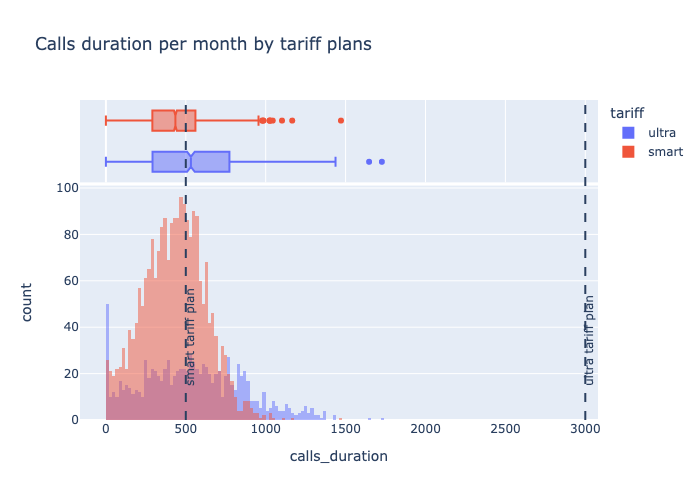

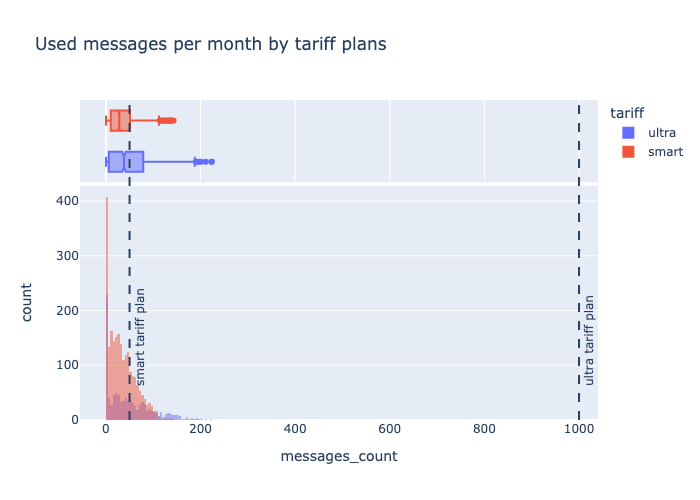

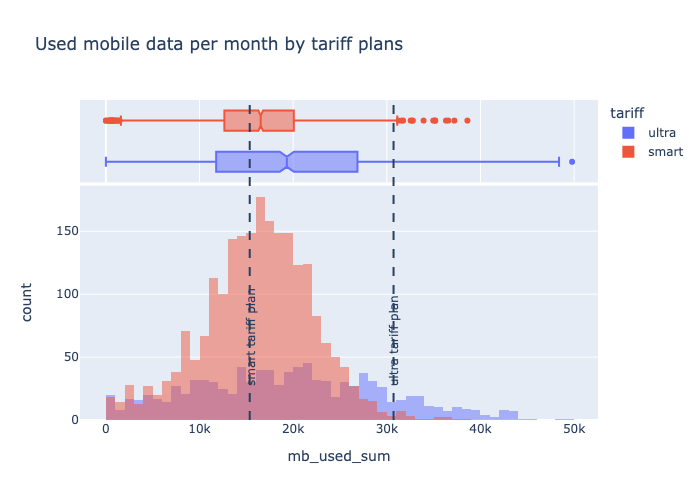

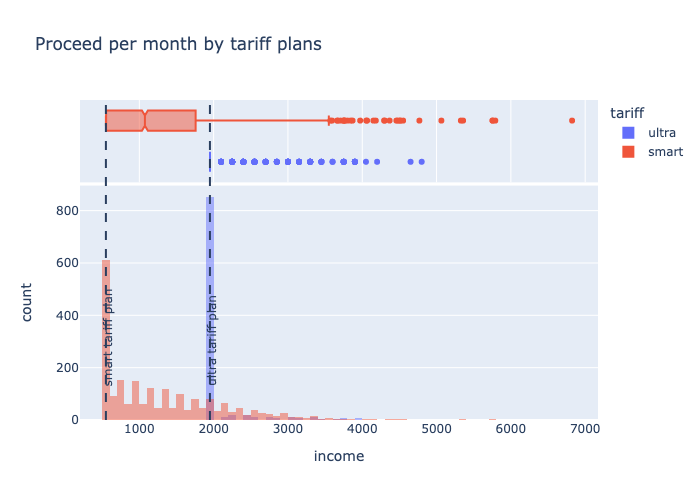

In [29]:
print("Distributions of clients' characteristics per month in comparison with inclusive tariff plans sets")
for parameter in [['calls_duration','Calls duration', 'minutes_included'],
                  ['messages_count','Used messages','messages_included'], 
                  ['mb_used_sum','Used mobile data', 'mb_per_month_included'], 
                  ['income','Proceed', 'rub_monthly_fee']] :
    fig = px.histogram(total, x=total[parameter[0]], color='tariff', title=parameter[1]+' per month by tariff plans',
                       marginal='box', barmode='overlay')
    for tarriff_list in [0,1]:
        fig.add_annotation(x=tariffs[parameter[2]][tarriff_list]+20, y=0.1, yref='paper', 
                           text=tariffs.tariff_name[tarriff_list] + ' tariff plan', textangle=270,
                           showarrow=False)
        fig.add_shape(type='line',x0=tariffs[parameter[2]][tarriff_list], y0=0, 
                      x1=tariffs[parameter[2]][tarriff_list], y1=1, 
                      xref='x', yref='paper',
                      line={'dash': 'dash'})
        
    fig.show(renderer='png');

#### Description
Calls' duration
- smart (500 included): 429 minutes in average, standard deviation is 195. Most of values are in range from 0 to 800 minutes. About 60% of clients use less then 500 included minutes.
- ultra (3000 included): 541 minutes in average, values are more dispersed in this tarif and standard deviation equals 326. Most of values are from 0 to 1200 minutes. All clients use less then included amount of minutes. 

Amount of messages
- smart (50 included): 33 sms in average, standard deviation is 28. Most of values are in range from 0 to 90 sms. Almost 75% of clients use less then included sms.
- ultra (1000 included): 49 sms in average, standard deviation is 48. Most of values are from 0 to 150 minutes. All clients use less then included amount of sms. 

<br>Median values are less then average, mostly clients in both tariffs use very little amount of messages, there's a peak in histogram where amount is less then 10.

Mobile data usage
- smart (15 360 Mb included): 16 229 Mb in average, standard deviation is 5 878. In average clients use a little more data then included in this tariff. Less then 50% of clients don't use extra internet data. Distribution is almost normal, median is 16 531.
- ultra (30 720 Mb included): 19 487 Mb in average, standard deviation is 10 096. Distribution is also close to normal. Median is 19 324. More than 75% of clients don't need extra mobile data.

### 5. Check hypothesis <a id="hypothesis_check"> <a>
1. Average procceds from client in different tariffs differ.
2. Average proceeed from client in city "Москва" (Moscow) differs from other regions.

Significance level alpha will be 5%

**Н0: Average incomes from client in tariffs Smart and Ultra are equal**
<br>**Н1:  Average incomes from client in tariffs Smart and Ultra are NOT equal**

In [30]:
alpha = 0.05
ar_smart = total[total['tariff'] == 'smart']['income'] 
ar_ultra = total[total['tariff'] == 'ultra']['income'] 
result = stats.ttest_ind (ar_smart, ar_ultra, equal_var=False) 
print('p-value:', result.pvalue)

if (result.pvalue < alpha):
    print("Average incomes from client in tariffs Smart and Ultra are NOT equal")
else:
    print("We fail to reject null hypothesis that average income is equal")
print('\nAverage incomes from client in tariff Smart: {:.2f}'.format(total[total['tariff'] == 'smart']['income'].mean()))
print('Average incomes from client in tariff  Ultra: {:.2f}'.format(total[total['tariff'] == 'ultra']['income'].mean()))


p-value: 2.2071398635388928e-234
Average incomes from client in tariffs Smart and Ultra are NOT equal

Average incomes from client in tariff Smart: 1311.62
Average incomes from client in tariff  Ultra: 2071.07


In [31]:
print("Sum income from each tariff:")
print("Smart:", total[total['tariff'] == 'smart']['income'].sum())
print("Ultra:", total[total['tariff'] == 'ultra']['income'].sum())

Sum income from each tariff:
Smart: 2923590.0
Ultra: 2040000.0


**Н0: Average income from client in Moscow and in other regions are equal**
<br>**Н1: Average income from client in Moscow and in other regions are NOT equal**

In [32]:
ar_msc = total[total['city'] == 'Москва']['income'] 
ar_region = total[total['city'] != 'Москва']['income'] 
result = stats.ttest_ind (ar_msc, ar_region, equal_var=False) 
print('p-value:', result.pvalue)

if (result.pvalue < alpha):
    print("Average income from client in Moscow and in other regions differ")
else:
    print("We fail to reject null hipothesis that income from client in Moscow and in other regions are equal")
    
print('\nAverage income in Moscow: {:.2f}'.format(total[total['city'] == 'Москва']['income'].mean()))
print('Average income in other regions: {:.2f}'.format(total[total['city'] != 'Москва']['income'].mean()))

p-value: 0.561222873696557
We fail to reject null hipothesis that income from client in Moscow and in other regions are equal

Average income in Moscow: 1560.57
Average income in other regions: 1540.56


### Summary
**What was done:**
- 5 tables were imported;
- data types and errors in data were corrected;
- all amount are rounded according to operator viewing;
- one pivot table is formed where we can see what volume of services every client used and what tariff he uses;
- every client's proceed is calculated per month;
- histograms for minute, sms, data amount distribution are formed. Distribution characteristics are analysed;
- hypothesis that tariffs' incomes differ is checked;
- hypothesis that income is different in Moscow and other cities is checked.


**Conclusions:**

More than 75% of Ultra don't need extra packages over their tariff and they pay only fixed monthly payment. In Smart tariff more than 50% of clients pay for extra data and obout 40% need extra minutes of calls, i.e. they pay more than monthly fixed fee.

Average income in tariff Ultra is bigger than in Smart.
<br>But there are 2.2 times more of Smart clients than Ultra and sum income from them is bigger. About 80% of them even with all extra payments pay less then monthly payment for Ultra. Thus most of Smart tariff clients now don't have any reason to change Smart to Ultra and pay more. And it looks more efficient to promote Ultra (that is more profittable for the provider) for new clients but not as an upgrade for present ones. 

Ultra is more profitable per one client but there are not so many people who need these big packages so we should know well the target audience to promote this tariff

Average income per client in Moscow and in other regions doesn't differ.